In [288]:
library(glmnet)
library(survival)
library(plyr)
library(caret)
library(survcomp)
library(rms)


In [301]:
all_data <- read.table('../data/final_data.tsv',sep='\t',header=TRUE, row.names=1)
# Two patients have survival times of -1 and -10, what does this mean? remove for now.
all_data = all_data[all_data$times >0,]

# separate training and test set
sample_size = floor(0.66 * nrow(all_data)) # grab 70% of data for training
set.seed(123) # Set random seed to make reproducible
training_indices = sample(seq_len(nrow(all_data)), size=sample_size)

train_data = all_data[training_indices,]
test_data = all_data[-training_indices,]

In [290]:
# Metadata is age, died, grade, idh, sex, times
# All other variables are inverse-normalized log-fold change expression values
survival_times = train_data[,c('times','died')]
survival_times = rename(survival_times, c('times'='time', 'died'='status'))
y = data.matrix(survival_times)
expression_and_metadata = train_data[, !names(train_data) %in% c('times', 'died')]
metadata_only = expression_and_metadata[, c('age','grade','idh','sex')]
x_exp = data.matrix(expression_and_metadata)
x_no_exp = data.matrix(metadata_only)

In [291]:
death_pen = 10 # Weigh the fit for patients that died more heavily than those that lived
cvfit_exp = cv.glmnet(x_exp, y, family = 'cox', weights = unlist(survival_times['status']*death_pen + 1), nlambda=100)
#cvfit_exp = cv.glmnet(x_exp, y, family = 'cox', nlambda=100)
cvfit_no_exp = cv.glmnet(x_no_exp, y, family = 'cox',  weights = unlist(survival_times['status']*death_pen + 1), nlambda=100)
#cvfit_no_exp = cv.glmnet(x_no_exp, y, family = 'cox', nlambda=100)

The plots below demonstrate the regularization behavior of LASSO--going from left to right on the x axis, there is an increasing penalty for including a covariate. The numbers on top of each plot indicate the number of active covariates at each value of lambda (the regularization/penalty term). The leftmost dashed line represents the minimum partial likelihood deviance (the optimization problem being solved attempts to minimize this) and the value of lambda at that minima. The rightmost dashed line is the most regularized covariate set within 1 standard error of the minima. The position of the rightmost line at ~10 active covariates for the model that includes lncRNA expression tells us that LASSO kept a few lncRNAs active within the cox model.

Age and IDH status are the covariates that end up in the no-expression model. Interestingly, in this case the expression model actually doesn't include IDH status (however, if we loosen the death_pen term used to construct the models, idh status is usually included. It is also included if we increase the size of our test set).

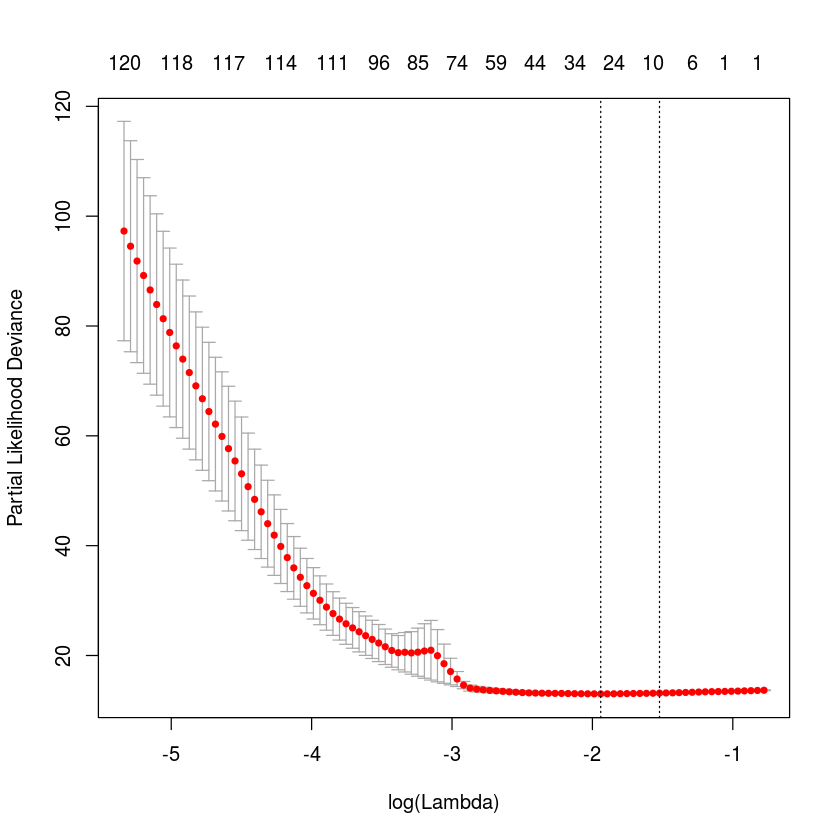

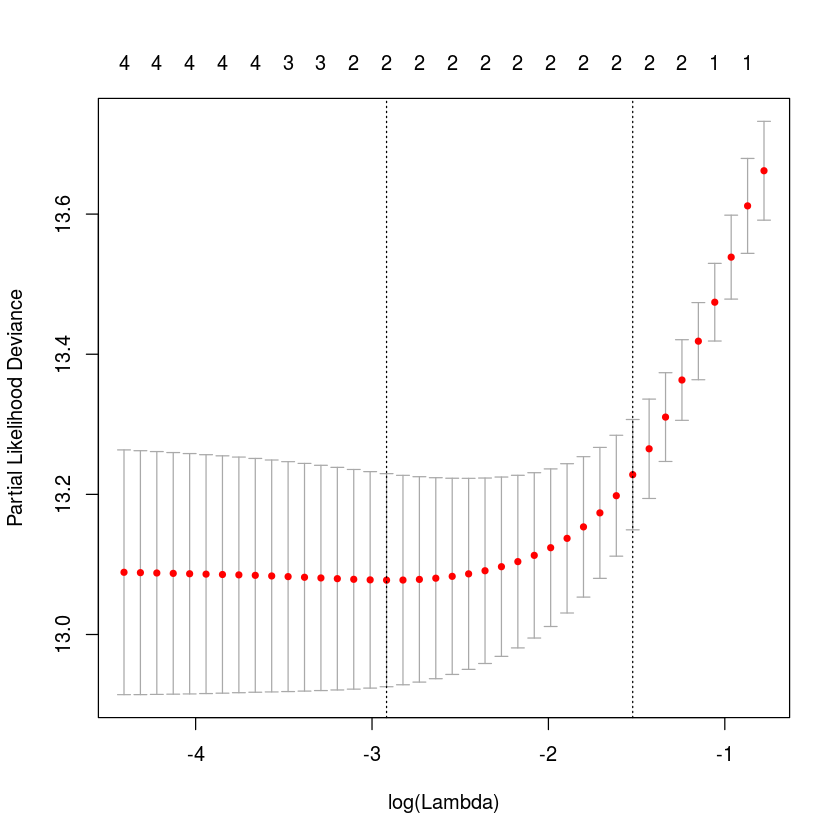

In [292]:
plot(cvfit_exp) # with lncRNA expression
plot(cvfit_no_exp) # without expression

In [293]:
cvfit_exp$lambda.min # give the value of value of lambda at min PLD (left line)

[1] 0.1436024

In [294]:
cvfit_exp$lambda.1se # gives the value of lamdba at most-regularized PLD within 1 SD of minimum (right line)

[1] 0.2182629

In [295]:
# We'll use the 1 SE coefficients for the rest of analysis.
coef.min = coef(cvfit_exp, s = "lambda.1se")
active.min = which(coef.min != 0)
index.min = coef.min[active.min]
index.min

coef_no_exp.min = coef(cvfit_no_exp, s = "lambda.1se")
active_no_exp.min = which(coef_no_exp.min != 0)
index_no_exp.min = coef_no_exp.min[active_no_exp.min]
index_no_exp.min

[1] -0.0002218093  0.0048364321 -0.0084013302  0.0373344549 -0.0270739426
 [6]  0.0221822175  0.0192339827 -0.0609444696 -0.0034472415  0.0335499305

[1]  0.03135602 -0.31433938

In [300]:
# This just displays the matrices w/ covariate names and corresponding coefficients
#coef.min
#coef_no_exp.min

In [297]:
# format test data
test_survival_times = test_data[,c('times','died')]
test_survival_times = rename(test_survival_times, c('times'='time', 'died'='status'))
test_y = data.matrix(test_survival_times)
test_expression_and_metadata = test_data[, !names(test_data) %in% c('times', 'died')]
test_metadata_only = test_expression_and_metadata[, c('age','grade','idh','sex')]
test_x_exp = data.matrix(test_expression_and_metadata)
test_x_no_exp = data.matrix(test_metadata_only)

In [298]:
exp_selected = rownames(coef.min)[active.min]
no_exp_selected = rownames(coef_no_exp.min)[active_no_exp.min]

exp_trained_x = data.matrix(expression_and_metadata[exp_selected])
no_exp_trained_x = data.matrix(expression_and_metadata[no_exp_selected])

#compute predictions with original glmnet model. This doesn't seem to be that functional in glmnet.
#predict_exp = predict(cvfit_exp, test_x_exp, s='lambda.min')
#predict_no_exp = predict(cvfit_no_exp, test_x_no_exp, s='lambda.min')

colnames(exp_trained_x)
colnames(no_exp_trained_x)


[1] "CH17.140K24.6" "CRNDE"         "KB.1460A1.5"   "LINC01057"    
 [5] "MORC2.AS1"     "RP11.303E16.2" "RP11.798M19.3" "RP4.669P10.16"
 [9] "RP5.1021I20.1" "age"

[1] "age" "idh"

In [299]:

# Use the glmnet cox coefficients to construct a coxph model - these can't be used with survest/rcorr
# exp_cox = coxph(Surv(as.numeric(survival_times$time),as.numeric(survival_times$status)) ~ exp_trained_x,init=index.min,iter=0,model=TRUE)
# no_exp_cox = coxph(Surv(as.numeric(survival_times$time),as.numeric(survival_times$status)) ~no_exp_trained_x,init=index_no_exp.min,iter=0)

# Use the glmnet cox coefficients to create cph cox models - these are compatible with survest/rcorr
exp_cox = cph(Surv(
    as.numeric(survival_times$time),as.numeric(survival_times$status)) ~ 
              CH17.140K24.6 + CRNDE + KB.1460A1.5 + LINC01057 + MORC2.AS1 + RP11.303E16.2 + RP11.798M19.3 + RP4.669P10.16 + RP5.1021I20.1 + age,
              data=expression_and_metadata[exp_selected],init=index.min,iter.max=0,surv=TRUE)
no_exp_cox = cph(Surv(
    as.numeric(survival_times$time),as.numeric(survival_times$status)) ~ 
                 age + idh, 
                 data=metadata_only[no_exp_selected],init=index_no_exp.min,iter.max=0,surv=TRUE)

# Produce survival probability estimates for test data
exp_estimates=survest(exp_cox,newdata=test_expression_and_metadata,times=1000)$surv
no_exp_estimates = survest(no_exp_cox,newdata=test_metadata_only,times=1000)$surv

# Calculate concordance within the test dataset
exp_concordance = rcorr.cens(x=exp_estimates,S=Surv(as.numeric(test_survival_times$time),as.numeric(test_survival_times$status)))
no_exp_concordance = rcorr.cens(x=no_exp_estimates,S=Surv(as.numeric(test_survival_times$time),as.numeric(test_survival_times$status)))

exp_concordance
no_exp_concordance

# Old code used for plotting individual survival curves:
# Do not compute standard error, penalized regression models cannot have accurate SE measures:
# https://cran.r-project.org/web/packages/penalized/vignettes/penalized.pdf
# a = survfit(exp_cox,newdata=test_expression_and_metadata[exp_selected],se.fit=FALSE)
# b = survfit(no_exp_cox,newdata=test_metadata_only[no_exp_selected],se.fit=FALSE)
# plot(a)
# plot(b)

Warning message:
In survest.cph(exp_cox, newdata = test_expression_and_metadata, : S.E. and confidence intervals are approximate except at predictor means.
Use cph(...,x=TRUE,y=TRUE) (and don't use linear.predictors=) for better estimates.Warning message:
In survest.cph(no_exp_cox, newdata = test_metadata_only, times = 1000): S.E. and confidence intervals are approximate except at predictor means.
Use cph(...,x=TRUE,y=TRUE) (and don't use linear.predictors=) for better estimates.

C Index            Dxy           S.D.              n        missing 
  8.287711e-01   6.575422e-01   8.850661e-02   1.520000e+02   0.000000e+00 
    uncensored Relevant Pairs     Concordant      Uncertain 
  2.800000e+01   3.434000e+03   2.846000e+03   1.951600e+04

C Index            Dxy           S.D.              n        missing 
  7.935352e-01   5.870705e-01   1.065897e-01   1.520000e+02   0.000000e+00 
    uncensored Relevant Pairs     Concordant      Uncertain 
  2.800000e+01   3.434000e+03   2.725000e+03   1.951600e+04